## Imports

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import json
import os
import pandas as pd
try: import dateparser
except:
    print('No Module called Dateparser. Installing Daterparser')
    !pip install dateparser
    import dateparser
from collections import defaultdict
import numpy as np

No Module called Dateparser. Installing Daterparser
     |████████████████████████████████| 368kB 2.7MB/s 


## Getting Data

Data is stored in the following folders:

*   timeseries_data [Click Here to see all timeseries graphs](#scrollTo=V4OXudKNBdJO&line=1&uniqifier=1)</br>
    * all.json --> Overall (whole Bangladesh) flood media articles data.
    * [division_name].json --> Flood Media articles data for each division
    * site_distribution.json --> Scraped Article Distribution vs years
*   other_data
    * Damage data_Hassan.csv --> Red Cross damage data for Bangladesh. [Click here to see data](#scrollTo=w7sR7EYur67-&line=1&uniqifier=1)
    * Flood_Affected_Area_Barchart.csv --> Government data for Area Affected by flood. [Click here to see data and graphs](#scrollTo=F5dytk6ADYcf&line=1&uniqifier=1)
    * pmv_cm_ts --> Passive Microwave data with 4 day moving Average of C/M Ratio for Rajshahi and Sylhet Division from 2017-2019 [Click here to see data and graphs](#scrollTo=pGEm9ZgYr68B)
    * pmw_flood_ts --> Passive Microwave data with total area flooded for Rajshahi and Sylhet Division from 2017-2019 [Click here to see data and graphs](#scrollTo=pGEm9ZgYr68B)
    * Sentinel1_ts --> Sentinel 1 data for Sylhet and Rajshahi Region [Click here to see data and graphs](#scrollTo=EZe_IrSvC_oS)


Data Explaination is given below


In [ ]:
# # Google Cloud Storage Config
# cloud_url = 'gs://bangladesh_flood_data/*'
# !gsutil -mq cp -r $cloud_url .
# print('Data Downloaded')

Data Downloaded


## Data Explaination

**Timeseries Data**

[Click Here to see all timeseries graphs](#scrollTo=V4OXudKNBdJO&line=1&uniqifier=1)

Timeseries shows year_published or month_published vs count of is_flood articles (articles that have been classified as mentioning flood events) for Bangladesh (all articles) and 7 divisions in Bangladesh (these are like states in a country).

There exists 4 timeseries per division/for Bangladesh. 

1.   Year Published of articles vs number of is_flood articles in that year (that talk about a flood event). 
2.   Articls from years 1984 to 2007, showing count per month (so a monthly count of is_flood articles from 1984 to 2007). <font color=red>*Some years are missing due to lack of data*</font>
3.   Articls from years 2008 to 2014, showing count per month (so a monthly count of is_flood articles from 2008 to 2014).
4.   Articls from years 2015 to 2020, showing count per month (so a monthly count of is_flood articles from 2015 to 2020). <font color=red>*2020 data is incomplete and recent data has not been fully added yet. Ongoing flood data isn't present*</font>

</br>

**Scraped Site Distribution**

[Click here to see data](#scrollTo=Jprz1RO9qoHi&line=1&uniqifier=1)

Number of is_flood articles per year and Total Number of articles scraped in a year.

</br>

**Red Cross damage data**

[Click here to see data](#scrollTo=w7sR7EYur67-&line=1&uniqifier=1)

Various quantities of damage done by floods (such as crops destroyed, houses destroyed etc) from 1986 to 2007. <font color=red>*This hasn't been plotted because most of the media data is from 2015 onwards, and very few entries exist for before 2007. Hence, there is very little to validate*</font>

</br>

**Government data for Area Affected by flood**

[Click here to see data and graphs](#scrollTo=F5dytk6ADYcf&line=1&uniqifier=1)

Area affected vs year. Data given by government. Plotted against the timeseries for Bangladesh data for yearPublished vs counts of is_flood articles.

</br>

**Passive Microwave Data**

[Click here to see data and graphs](#scrollTo=pGEm9ZgYr68B)

Passive Microwave satellite shows the backscatter of light *(not sure about this)* when light microwaves get reflected from water. C/M Ratio measures scatter of a given region relative to surrounding *(not sure about this either)*. Higher C/M Ratio = more water *(SURE ABOUT THIS!)*

Data is collected daily and given the nature of data  (energy reflected is low), it is collected over a large region. The data here is collected over a 3 sq km region.

This data is divided in two parts.

1.   <u>4 day moving average of C/M Ratio:</u></br>
      PMW data, in itself is very noisy, as it is collected daily and is highly succestible to fluctuations (check [next cell](#scrollTo=BkbJ2FvRTjVD&line=1&uniqifier=1) and hence a 4 day moving average gives a better result.
2.   <u>Total Area Flooded:</u></br>
        This was calculated by thresholding the C/M Ratio with a standard deviation of 2. (So any pixel/region above a 2 std value of C/M Ratio was counted as a flooded region. Total Area = No of Pixels $\times$ 3 sq km)

</br>

**Sentine 1 Data**

[Click here to see data and graphs](#scrollTo=EZe_IrSvC_oS)

Number of Articles Containing Flood Events and 1,000,000,000 * Total Area Flooded (Sentinel1) vs Year-Month of flood event

</br>

**EM-DAT Data**

[Click here to see data and graphs](#scrollTo=Lzh33EgbDPf9)

* Data for all disasters in the world
* Inclusion Criteria: 10+ people killed, 100+ people affected, state of emergency declared



### Problems with PMW Data

1.   Collected over large region/area - Data becomes less accurate
2.   C/M Ratio takes into account water. Which means soil Moisture is also included. Some peaks seen around January (Dry season) are often result of irrigation that has been done in the region)



## Parsing and Plotting Data Functions

In [ ]:
def calculate_ylim(y_data):
    minVal, maxVal, total = min(y_data), max(y_data), len(y_data)
    add_factor = np.std(y_data)
    return minVal, maxVal+add_factor

def plot_timeseries(l, title='', xlabel='', ylabel='', xticks_rotate=False, skip=False):
    plt.figure(figsize=(15,7))
    colors = ['b', 'r', 'g', 'o']
    for i,entry in enumerate(l):
        plot_color = entry.get('color',colors[i])
        if entry.get('type', None)=='bar':
            plt.bar([i[0] for i in entry['count_list']], [i[1] for i in entry['count_list']], 
                    color=plot_color, label=entry['label'])
        else:
            plt.plot([i[0] for i in entry['count_list']], [i[1] for i in entry['count_list']], 
                     linestyle='-', marker='o', color=plot_color, label=entry['label'])
        plt.xticks([i[0] for i in entry['count_list']])
            
    plt.legend(fontsize=18)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xticks_rotate: plt.xticks(rotation='vertical')
    
    if skip:
        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::3]))
        for label in temp:
            label.set_visible(False)
    plt.show()

def plot_2timeseries(l1, l2, title='', xlabel='', xticks_rotate=False, skip=False):
    plt.figure(figsize=(15,7))
    
    
    # l1
    fig, ax1 = plt.subplots(figsize=(15,7))
    plot_color = l1.get('color','r')
    if l1.get('type', None)=='bar':
        ax1.bar([i[0] for i in l1['count_list']], [i[1] for i in l1['count_list']], 
                    color=plot_color, label=l1['label'])
    else:
        ax1.plot([i[0] for i in l1['count_list']], [i[1] for i in l1['count_list']], 
                 linestyle='-', marker='o', color=plot_color, label=l1['label'])
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(l1.get('ylabel',''), color=plot_color)
    ax1.tick_params(axis='y', labelcolor=plot_color)
    ax1.tick_params(axis='x', labelrotation=90 if xticks_rotate else None)
    ax1.legend(fontsize=15, loc='upper left')
    minVal, maxVal = calculate_ylim([i[1] for i in l1['count_list']])
    ax1.set_ylim(minVal, maxVal)
    
    #l2
    ax2 = ax1.twinx()
    plot_color = l2.get('color','b')
    if l2.get('type', None)=='bar':
        ax2.bar([i[0] for i in l2['count_list']], [i[1] for i in l2['count_list']], 
                    color=plot_color, label=l1['label'])
    else:
        ax2.plot([i[0] for i in l2['count_list']], [i[1] for i in l2['count_list']], 
                 linestyle='-', marker='o', color=plot_color, label=l2['label'])
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(l2.get('ylabel',''), color=plot_color)
    ax2.tick_params(axis='y', labelcolor=plot_color)
    ax2.tick_params(axis='x', labelrotation=90 if xticks_rotate else None)
    ax2.legend(fontsize=15, loc='upper right')
    minVal, maxVal = calculate_ylim([i[1] for i in l2['count_list']])
    ax2.set_ylim(minVal, maxVal)

    plt.xticks([i[0] for i in l2['count_list']])
    
    fig.suptitle(title, fontsize=18, y=title.count('\n')*.05+1.01)
#     if xticks_rotate: fig.xticks(rotation='vertical')
    if skip:
        temp = ax1.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::3]))
        for label in temp:
            label.set_visible(False)
    fig.tight_layout()
    plt.show()

def load_year(d, year_range = [None, None]):
    d = {int(k):v for k,v in d.items()}
    all_years = set(d.keys())
    min_year, max_year = min(all_years), max(all_years)
    min_range = year_range[0] if year_range[0] is not None else min_year
    max_range = year_range[1] if year_range[1] is not None else max_year
    all_years = sorted([y for y in all_years if min_range<=y<=max_range])
    d_years = {k:d.get(k, 0) for k in all_years}
    years = [(int(k),float(v)) for k,v in d_years.items()]
    years.sort(key=lambda x:int(x[0]))
    return years

def load_year_month(d, year_range = [None, None]):
    
    # year_month = [(k,float(v)) for k,v in d.items()]
    all_years = set([int(i.split('-')[0]) for i in d.keys()])
    min_year, max_year = min(all_years), max(all_years)
    min_range = year_range[0] if year_range[0] is not None else min_year
    max_range = year_range[1] if year_range[1] is not None else max_year
    all_years = sorted([y for y in all_years if min_range<=y<=max_range])
    year_months = [str(i)+'-'+str(count) for i in all_years for count in range(1,13)]
    d_year_month = {k:d.get(k, 0) for k in year_months}
    year_month_list = sorted([(k,v) for k,v in d_year_month.items()], 
                key=lambda x:(int(x[0].split('-')[0]), int(x[0].split('-')[1])))

    return year_month_list

def match_years(list1, list2, match_type='add', complete=False):
    match_type = match_type.lower()
    l1 = set([int(i[0]) for i in list1])
    l2 = set([int(i[0]) for i in list2])
    if match_type=='add':
        ls1 = list1 + [(i,0) for i in l2-l1]
        ls2 = list2 + [(i,0) for i in l1-l2]
    elif match_type=='remove':
        not_present1, not_present2 = l2-l1, l1-l2
        ls1 = [i for i in list1 if i[0] not in not_present2]
        ls2 = [i for i in list2 if i[0] not in not_present1]
    else: raise Exception('match_type should be add or remove')
    
    if complete:
        l1 = [int(i[0]) for i in ls1]
        l2 = [int(i[0]) for i in ls2]
        min_year = min(l1 + l2)
        max_year = max(l1 + l2)
        ls1 += [(i,0) for i in range(min_year, max_year+1) if i not in l1]
        ls2 += [(i,0) for i in range(min_year, max_year+1) if i not in l2]
    return sorted(ls1, key=lambda x:int(x[0])), sorted(ls2, key=lambda x:int(x[0]))

def match_years_months(list1, list2, year_range = [2017, None]):
    dict1_year_months = {i[0]:i[1] for i in list1}
    dict2_year_months = {i[0]:i[1] for i in list2}
    
    set1_years = set([int(i.split('-')[0]) for i in dict1_year_months.keys()])
    set2_years = set([int(i.split('-')[0]) for i in dict2_year_months.keys()])
    all_years = set1_years.union(set2_years)
    
    min_year, max_year = min(all_years), max(all_years)
    min_range = year_range[0] if year_range[0] is not None else min_year
    max_range = year_range[1] if year_range[1] is not None else max_year
    all_years = sorted([y for y in all_years if min_range<=y<=max_range])
    
    list1_year_months = [str(i)+'-'+str(count) for i in all_years for count in range(1,13)]
    list2_year_months = [str(i)+'-'+str(count) for i in all_years for count in range(1,13)]
    d1_year_month = {k:dict1_year_months.get(k, 0) for k in list1_year_months}
    d2_year_month = {k:dict2_year_months.get(k, 0) for k in list2_year_months}
    l1 = sorted([(k,v) for k,v in d1_year_month.items()], 
                key=lambda x:(int(x[0].split('-')[0]), int(x[0].split('-')[1])))
    l2 = sorted([(k,v) for k,v in d2_year_month.items()], 
                key=lambda x:(int(x[0].split('-')[0]), int(x[0].split('-')[1])))
    return l1, l2


def aggregate_data_month(dates_vals, aggregate_func=max):
    dates_vals = [(dateparser.parse(i[0]), i[1]) for i in dates_vals]
    month_vals = defaultdict(float)
    for (date, val) in dates_vals:
        year, month = date.year, date.month
        year_month_str = '{}-{}'.format(year, month)
        month_vals[year_month_str] = aggregate_func(month_vals[year_month_str],val)
    return load_year_month(month_vals)
            
    
def plot_year_yearmonth_load(load_filepath, main_title='', plot=True):
    data = json.load(open(load_filepath))
    yearPublished = data['yearPublished']
    yearMonthPublished = data['yearMonthPublished']
    
    yearPublished_count_list = load_year(yearPublished)
    yearPublished_month_count_list_2007 = load_year_month(yearMonthPublished, year_range=[None, 2007])
    yearPublished_month_count_list_2014 = load_year_month(yearMonthPublished, year_range=[2008, 2014])
    yearPublished_month_count_list_2020 = load_year_month(yearMonthPublished, year_range=[2015, None])
    
    if plot:
        plot_timeseries([
            {'count_list': yearPublished_count_list, 'label':'Article YearPublished'},
        ], main_title+' Article YearPublished vs Year Counts', 'Year', 'Year Counts', True)

        plot_timeseries([
            {'count_list': yearPublished_month_count_list_2007, 'label':'Article YearPublished'},
        ], main_title+' Article YearPublished vs Year-Month Counts - 2007', 'Year-Month', 
            'Year-Month Counts', True, True)

        plot_timeseries([
            {'count_list': yearPublished_month_count_list_2014, 'label':'Article YearPublished'},
        ], main_title+' Article YearPublished vs Year-Month Counts - 2014', 'Year-Month', 
            'Year-Month Counts', True, True)

        plot_timeseries([
            {'count_list': yearPublished_month_count_list_2020, 'label':'Article YearPublished'},
        ], main_title+' Article YearPublished vs Year-Month Counts - 2020', 'Year-Month', 
            'Year-Month Counts', True, True)
    return yearPublished_count_list, yearPublished_month_count_list_2007, \
            yearPublished_month_count_list_2014, yearPublished_month_count_list_2020

## Media Data Timeseries

### Regular Timeseries

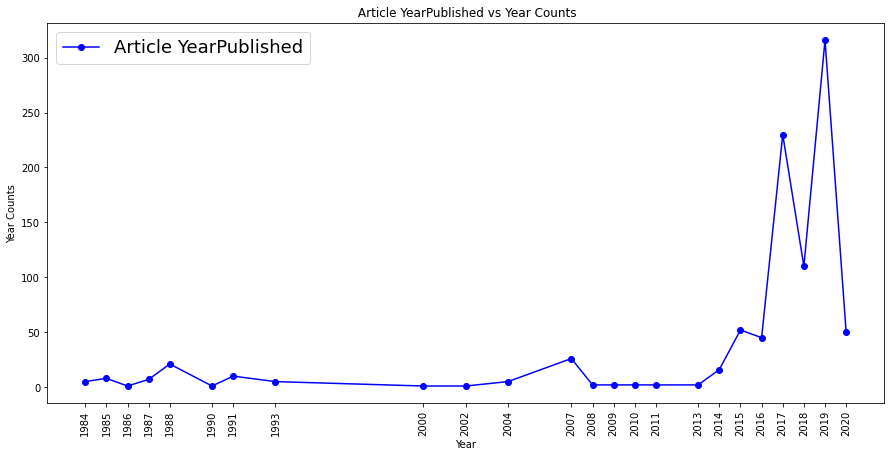

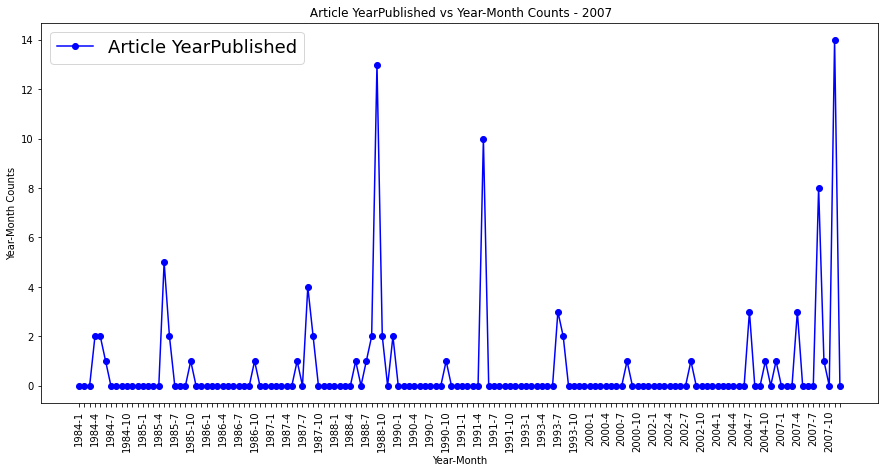

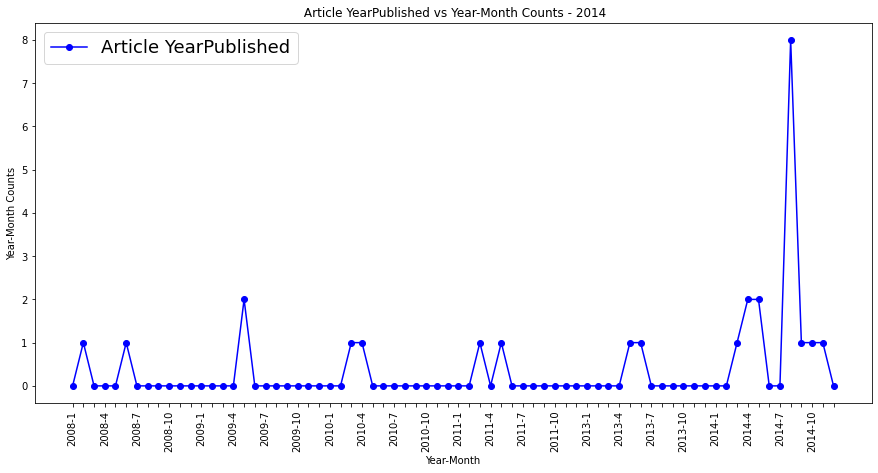

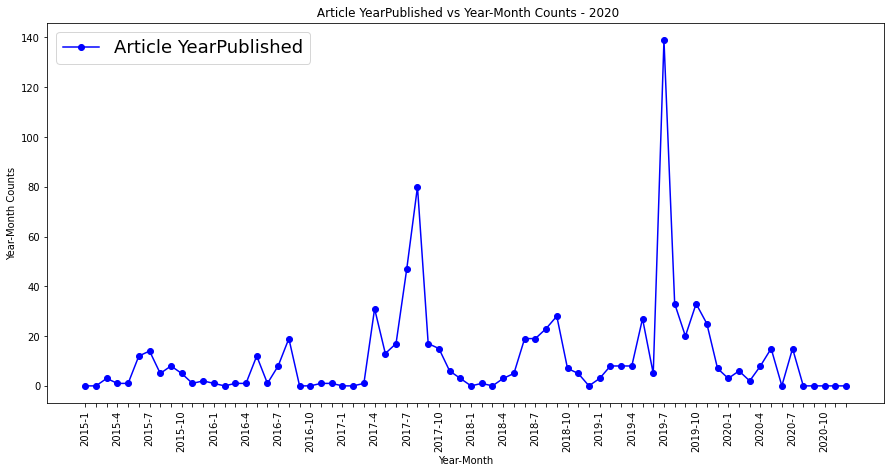

In [ ]:
ym = plot_year_yearmonth_load('timeseries_data/all.json', '')
# ym = plot_year_yearmonth_load('timeseries_data/sylhet.json', 'REGION: Sylhet')
# ym = plot_year_yearmonth_load('timeseries_data/chittagong.json', 'REGION: Chittagong')
# ym = plot_year_yearmonth_load('timeseries_data/dhaka.json', 'REGION: Dhaka')
# ym = plot_year_yearmonth_load('timeseries_data/rangpur.json', 'REGION: Rangpur')
# ym = plot_year_yearmonth_load('timeseries_data/rajshahi.json', 'REGION: Rajshahi')
# ym = plot_year_yearmonth_load('timeseries_data/khulna.json', 'REGION: Khulna')
# ym = plot_year_yearmonth_load('timeseries_data/barisal.json', 'REGION: Barisal')


### Scraped Site Distribution

Total Number of Sites Scraped (Regardless of flood event articles or not) from all newspapers and flood event articles extracted from these sites vs Year Published

<Figure size 1080x504 with 0 Axes>

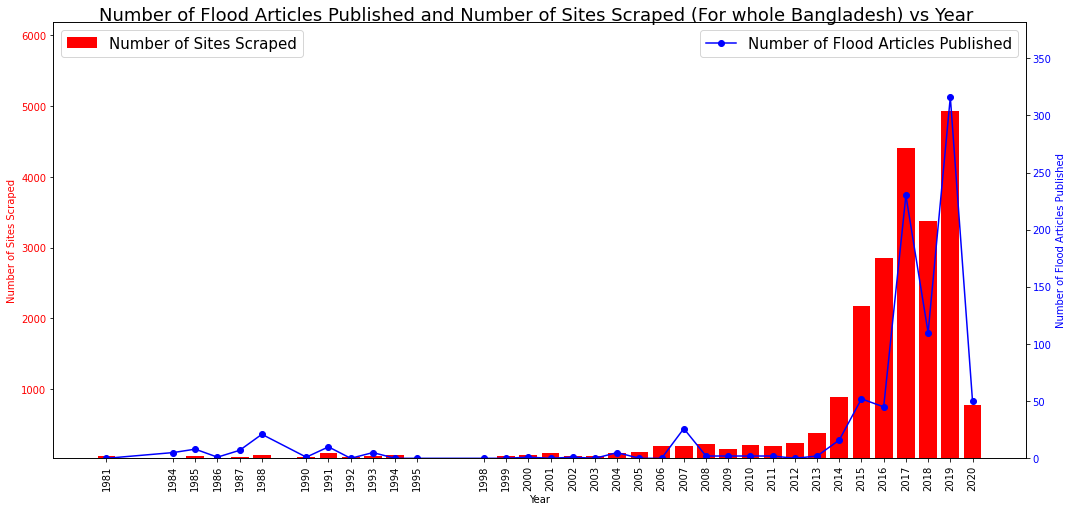

In [ ]:
site_distribution = json.load(open('timeseries_data/site_distribution.json'))
site_distribution_list = load_year(site_distribution)

yearPublished_count_list, yearPublished_month_count_list_2007, yearPublished_month_count_list_2014, \
yearPublished_month_count_list_2020 = plot_year_yearmonth_load('timeseries_data/all.json', '', plot=False)
yearPublished_count_list, site_distribution_list = match_years(yearPublished_count_list, site_distribution_list)
plot_2timeseries(
            {'count_list': site_distribution_list, 'label':'Number of Sites Scraped', 
             'type': 'bar', 'color':'r', 'ylabel':'Number of Sites Scraped'},
            {'count_list': yearPublished_count_list, 'label':'Number of Flood Articles Published', 
             'color': 'b', 'ylabel': 'Number of Flood Articles Published'},
            'Number of Flood Articles Published and Number of Sites Scraped (For whole Bangladesh) vs Year', 'Year', True)

## Comparisons

### Government Area Affected Data

In [ ]:
filepath = 'other_data/Flood_Affected_Area_Barchart.csv'
faf_df = pd.read_csv(filepath)
faf_df.head()

,Year,Flood affected area,Sq-Km %
0,1954,36800,25.0
1,1955,50500,34.0
2,1956,35400,24.0
3,1960,28400,19.0
4,1961,28800,20.0


<Figure size 1080x504 with 0 Axes>

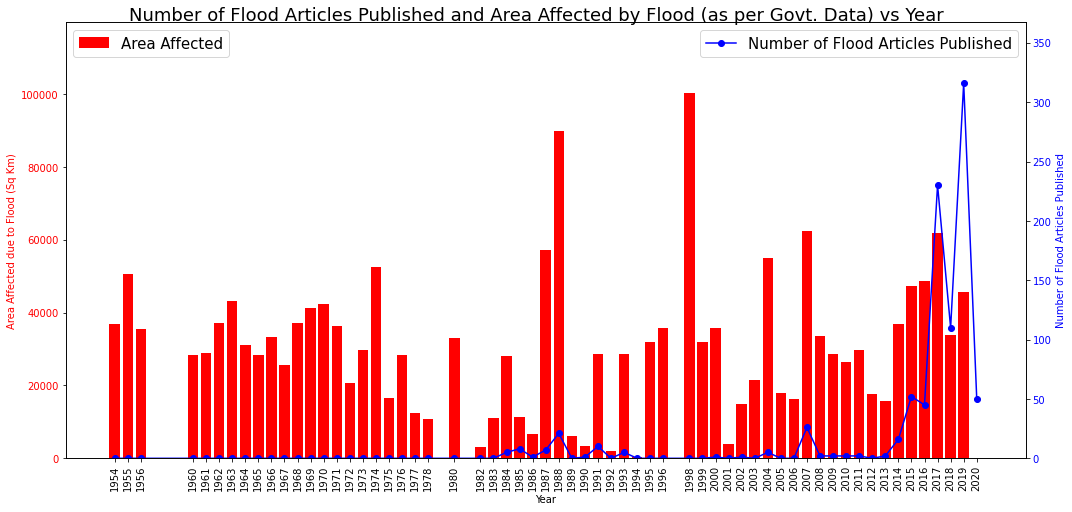

In [ ]:
faf_year_flood_affected = [(row[1]['Year'], int(row[1]['Flood affected area'].replace(',',''))) 
                           for row in faf_df.iterrows()]

yearPublished_count_list, yearPublished_month_count_list_2007, yearPublished_month_count_list_2014, \
yearPublished_month_count_list_2020 = plot_year_yearmonth_load('timeseries_data/all.json', '', plot=False)
yearPublished_count_list, faf_year_flood_affected = match_years(yearPublished_count_list, faf_year_flood_affected)

plot_2timeseries(
            {'count_list': faf_year_flood_affected, 'label':'Area Affected', 
             'type': 'bar', 'color':'r', 'ylabel':'Area Affected due to Flood (Sq Km)'},
            {'count_list': yearPublished_count_list, 'label':'Number of Flood Articles Published', 
             'color': 'b', 'ylabel': 'Number of Flood Articles Published'},
            'Number of Flood Articles Published and Area Affected by Flood (as per Govt. Data) vs Year', 'Year', True)

### Red Cross Damage Data

In [ ]:
filepath = 'other_data/Damage data_Hassan.csv'
damage_df = pd.read_csv(filepath)
damage_df = damage_df.fillna(0)
damage_df['Embankment Damages'] = pd.to_numeric(damage_df['Embankment Damages'], errors='coerce').fillna(0)
damage_df

,Year,No. of Dead People,No. of House damage Fully,No. of House Damage (Partialy),Crops damaged Fully (Acre),Crops damage Partialy (Acre),No. of Dead Livestock,Road Damage Fully (Km),Road Damage Partialy (km),Embankment Damages
0,1986,57,196803,279212,990573,711616,42374,3094,1610,13.0
1,1987,1470,71572,1691104,2983362,1873207,370129,12624,11534,1272.0
2,1988,1621,1151189,2536408,1119998,9993436,398018,47042,19675,1718.0
3,1989,23,3203,16096,58568,102716,51548,289,2195,0.0
4,1990,41,14101,58418,37987,125089,8716,171,1210,125.0
5,1991,818,340043,573446,1220225,1065044,46306,1692,8919,649.0
6,1993,162,234393,615336,778513,521204,29512,4367,12217,1013.0
7,1994,10,19177,31005,55325,48133,8666,60,475,18.0
8,1995,246,898708,2014027,2823751,2023314,58100,8881,13463,2876.0
9,1996,76,218275,598818,404456,605312,47946,1635,10922,448.0


### Passive Microwave data

In [ ]:
def compare_PMW_NLP(division):
    folderpath_pmw_cm, folderpath_pmw_flood = 'other_data/pmv_cm_ts', 'other_data/pmw_flood_ts'
    files_pmw_cm = [f for f in os.listdir(folderpath_pmw_cm) if '.csv' in f]
    files_pmw_flood = [f for f in os.listdir(folderpath_pmw_flood) if '.csv' in f]
    pmw_cv_df, pmw_flood_df = None, None
    for filepath in files_pmw_cm:
        if division.lower() not in filepath.lower(): continue
        temp_df = pd.read_csv(os.path.join(folderpath_pmw_cm, filepath))
        if pmw_cv_df is None: pmw_cv_df = temp_df
        else: pmw_cv_df = pd.concat([pmw_cv_df,temp_df])
    for filepath in files_pmw_flood:
        if division.lower() not in filepath.lower(): continue
        temp_df = pd.read_csv(os.path.join(folderpath_pmw_flood, filepath))
        if pmw_flood_df is None: pmw_flood_df = temp_df
        else: pmw_flood_df = pd.concat([pmw_flood_df,temp_df])
            
    yearPublished_count_list, yearPublished_month_count_list_2007, yearPublished_month_count_list_2014, \
    yearPublished_month_count_list_2020 = plot_year_yearmonth_load('timeseries_data/{}.json'.format(division), '', plot=False)
    
    pmw_cv_df_list = [(row[1]['Date'], row[1]['C/M ratio']) for row in pmw_cv_df.iterrows()]
    pmw_cv_month_count_list = aggregate_data_month(pmw_cv_df_list)
    yearPublished_month_count_list_2019, pmw_cv_month_count_list_2019 \
        = match_years_months(yearPublished_month_count_list_2020, pmw_cv_month_count_list, year_range=[2017, 2019])

    plot_2timeseries(
            {'count_list': pmw_cv_month_count_list_2019, 'label':'4 day moving averages of raw C/M Ratio from PMW', 
             'color':'r', 'ylabel':'C/M PMW raw ratio'},
            {'count_list': yearPublished_month_count_list_2019, 'label':'Number of Articles Published', 
             'color': 'b', 'ylabel': 'Number of Articles Published'},
            '{} Number of Articles Containing Flood Events and 4 Day moving Average of\n\
C/M Ratio vs Year-Month of flood event'.format(division.upper()), 'Year-Month', True)
    
    pmw_flood_df_list = [(row[1]['Date'], row[1]['Total Flooded Area']) for row in pmw_flood_df.iterrows()]
    pmw_flood_month_count_list = aggregate_data_month(pmw_flood_df_list)
    yearPublished_month_count_list_2019, pmw_flood_month_count_list_2019 \
        = match_years_months(yearPublished_month_count_list_2020, pmw_flood_month_count_list, year_range=[2017, 2019])
    
    plot_2timeseries(
            {'count_list': pmw_flood_month_count_list_2019, 
             'label':'Area Flooded (thresholding C/M signal at 2 std dev)', 
             'color':'r', 'ylabel':'Total Area Flooded'},
            {'count_list': yearPublished_month_count_list_2019, 'label':'Number of Articles Published', 
             'color': 'b', 'ylabel': 'Number of Articles Published'},
            '{} Number of Articles Containing Flood Events and Total Area Flooded (thresholding C/M\n\
signal at 2 std dev) vs Year-Month of flood event'.format(division.upper()), 'Year-Month', True)
    
    pmw_flood_fraction_df_list = [(row[1]['Date'], row[1]['Fraction of District Flooded']) for row in pmw_flood_df.iterrows()]
    pmw_flood_fraction_month_count_list = aggregate_data_month(pmw_flood_fraction_df_list)
    yearPublished_month_count_list_2019, pmw_flood_fraction_month_count_list_2019 \
        = match_years_months(yearPublished_month_count_list_2020, pmw_flood_fraction_month_count_list, year_range=[2017, 2019])

    plot_2timeseries(
            {'count_list': pmw_flood_fraction_month_count_list_2019, 
             'label':'Fraction Flooded Flooded (thresholding C/M signal at 2 std dev)', 
             'color':'r', 'ylabel':'Fraction District Flooded'},
            {'count_list': yearPublished_month_count_list_2019, 'label':'Number of Articles Published', 
             'color': 'b', 'ylabel': 'Number of Articles Published'},
            '{} Number of Articles Containing Flood Events and Fraction District Flooded (thresholding\n\
C/M signal at 2 std dev) vs Year-Month of flood event'.format(division.upper()), 'Year-Month', True)


<Figure size 1080x504 with 0 Axes>

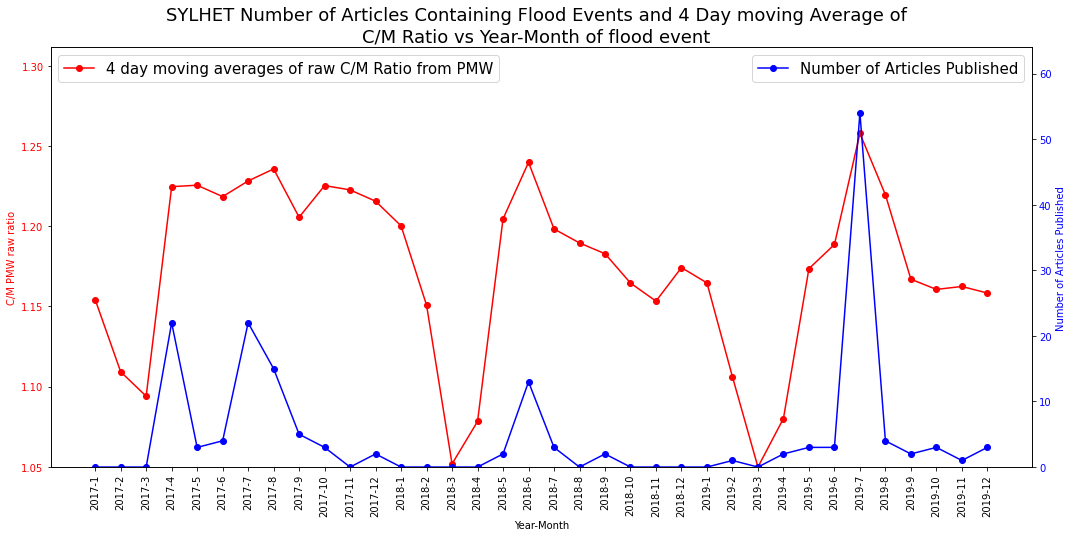

<Figure size 1080x504 with 0 Axes>

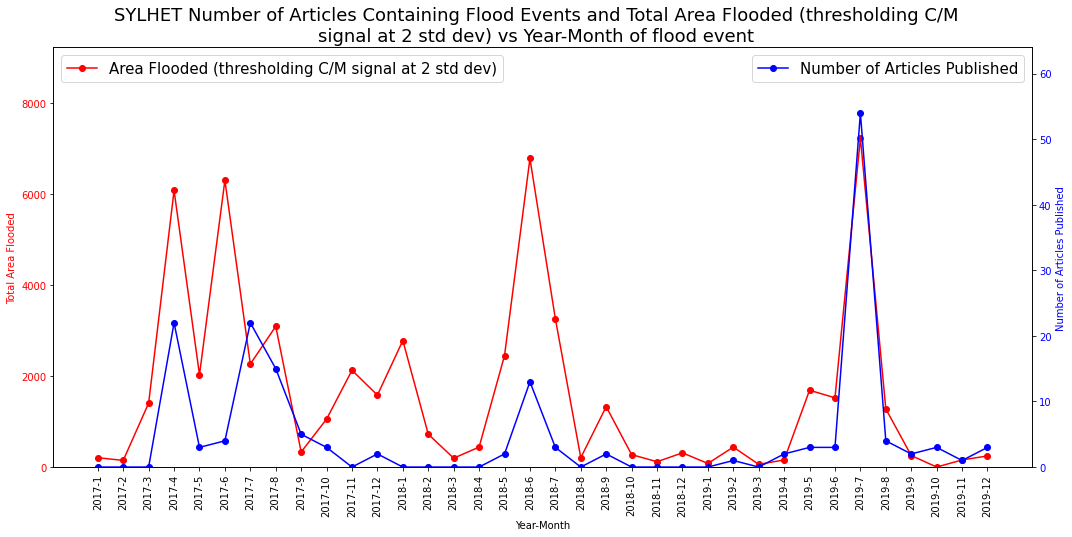

<Figure size 1080x504 with 0 Axes>

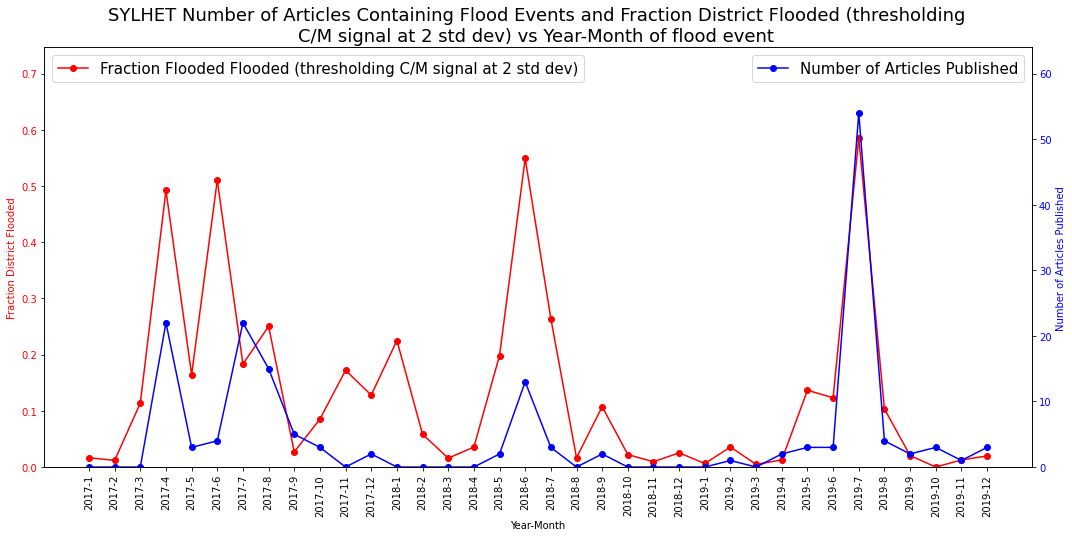

In [ ]:
compare_PMW_NLP('sylhet')

<Figure size 1080x504 with 0 Axes>

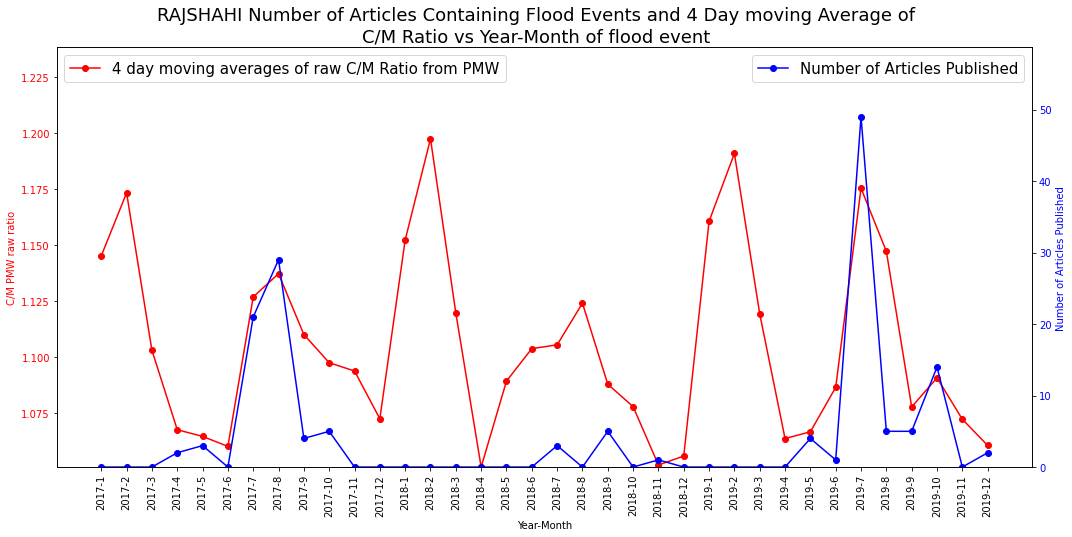

<Figure size 1080x504 with 0 Axes>

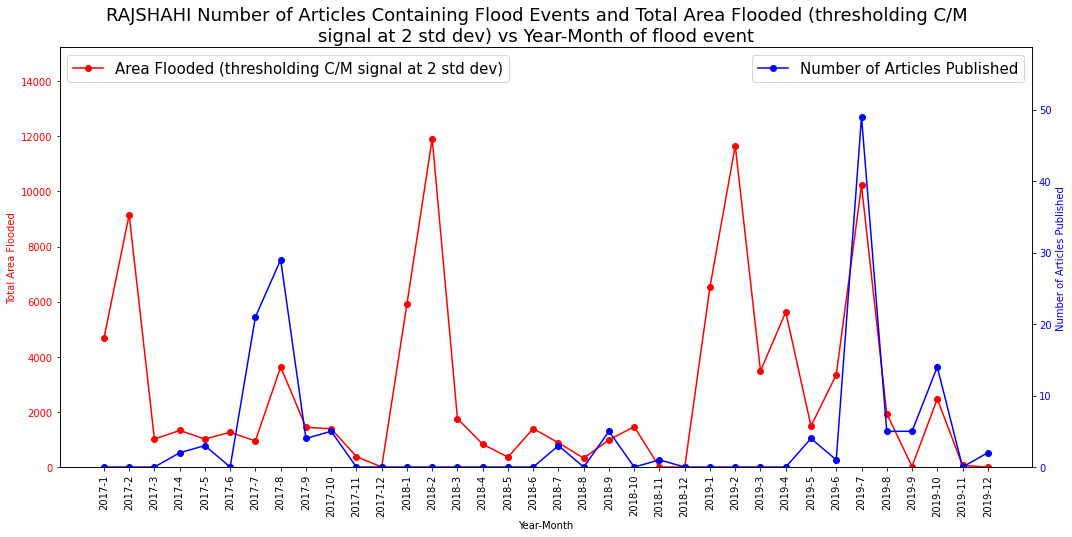

<Figure size 1080x504 with 0 Axes>

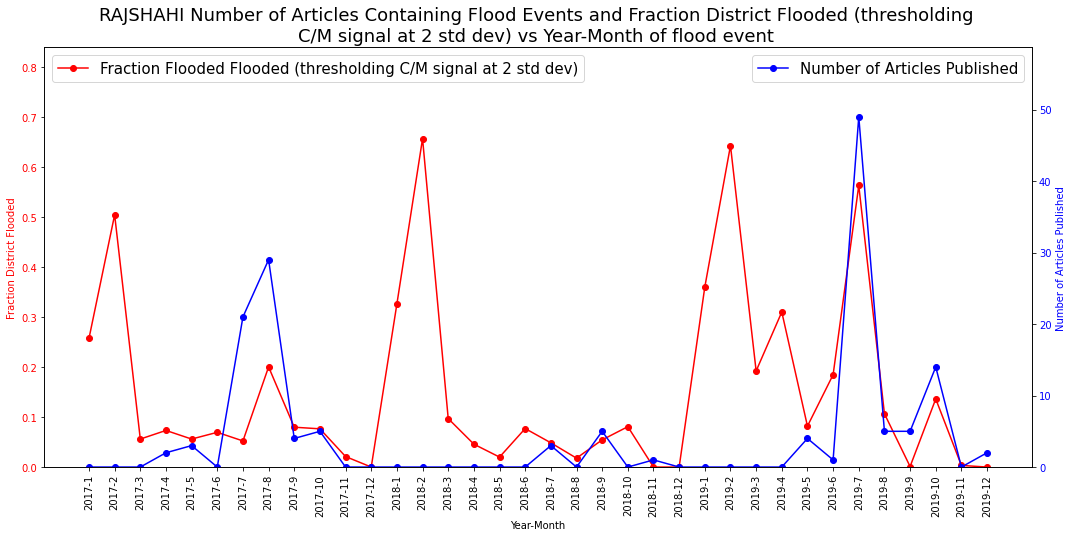

In [ ]:
compare_PMW_NLP('rajshahi')

### Sentinel 1 Data

In [ ]:
def compare_Sentinel_NLP(division):
    folderpath_s1 = 'other_data/Sentinel1_ts'
    files_s1 = [f for f in os.listdir(folderpath_s1) if '.csv' in f]
    s1_df = None
    for filepath in files_s1:
        if division.lower() not in filepath.lower(): continue
        temp_df = pd.read_csv(os.path.join(folderpath_s1, filepath))
        if s1_df is None: s1_df = temp_df
        else: s1_df = pd.concat([s1_df,temp_df])
    yearPublished_count_list, yearPublished_month_count_list_2007, yearPublished_month_count_list_2014, \
    yearPublished_month_count_list_2020 = plot_year_yearmonth_load('timeseries_data/{}.json'.format(division), '', plot=False)
    
    s1_df_list = [(row[1]['Dates'], row[1]['Flooded Area (m^2)']) for row in s1_df.iterrows()]
    s1_month_count_list = aggregate_data_month(s1_df_list)
    yearPublished_month_count_list_2019, s1_month_count_list_2019 \
        = match_years_months(yearPublished_month_count_list_2020, s1_month_count_list, year_range=[2017, 2019])

    plot_2timeseries(
            {'count_list': s1_month_count_list_2019, 'label':'1,000,000,000 * Total Area Flooded', 
             'color':'r', 'ylabel':'Sentinel1 1,000,000,000 * Total Area Flooded'},
            {'count_list': yearPublished_month_count_list_2019, 'label':'Number of Articles Published', 
             'color': 'b', 'ylabel': 'Number of Articles Published'},
            '{} Number of Articles Containing Flood Events and 1,000,000,000 * Total Area Flooded (Sentinel1)\n\
vs Year-Month of flood event'.format(division.upper()), 'Year-Month', True)


<Figure size 1080x504 with 0 Axes>

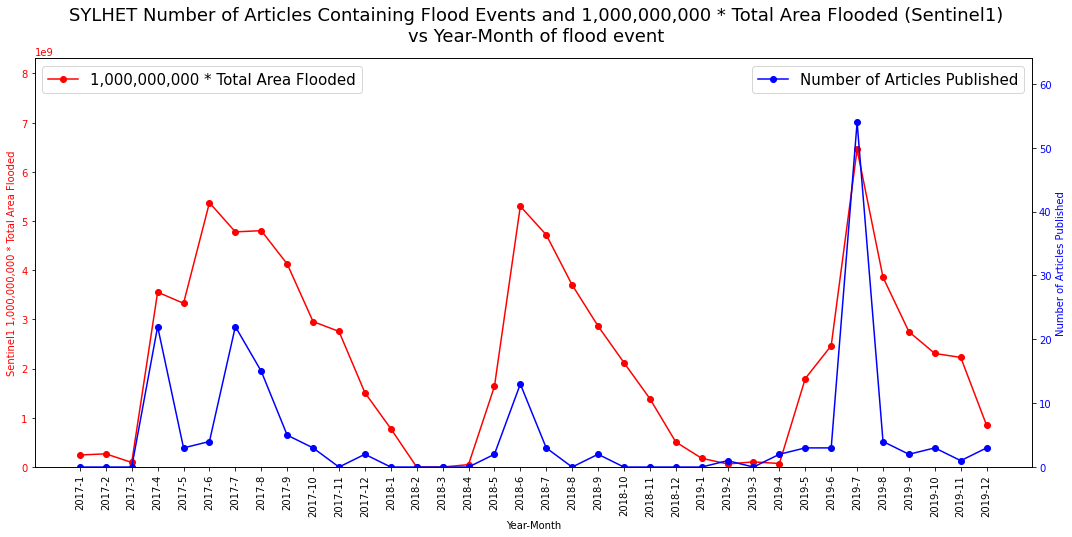

In [ ]:
compare_Sentinel_NLP('sylhet')

<Figure size 1080x504 with 0 Axes>

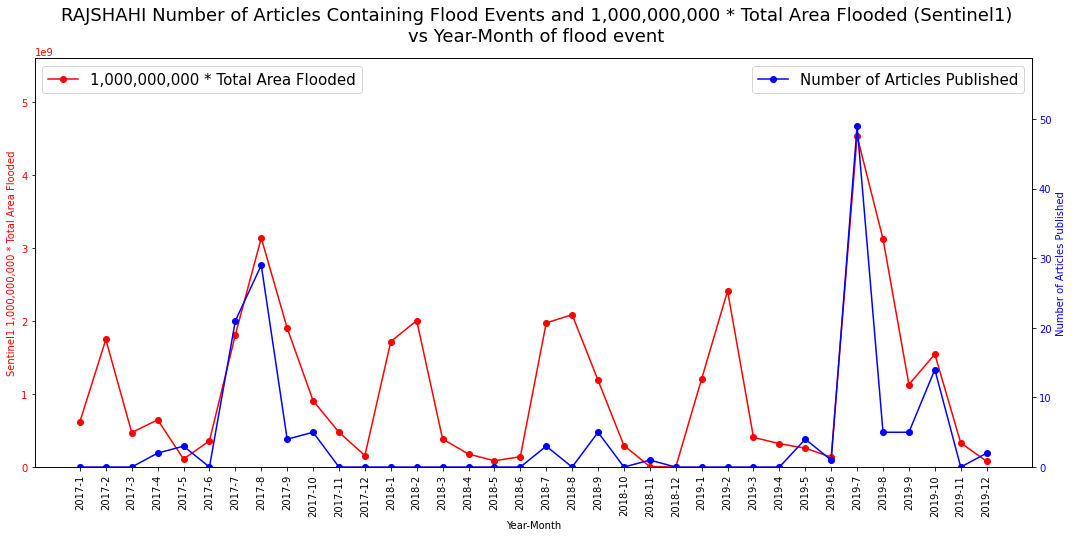

In [ ]:
compare_Sentinel_NLP('rajshahi')

### EM-DAT Data

In [ ]:
emdat_df = pd.read_csv('other_data/emdat_flood.csv').drop('Unnamed: 0', axis=1).fillna(0)


#### Monthly people affected comparison

<Figure size 1080x504 with 0 Axes>

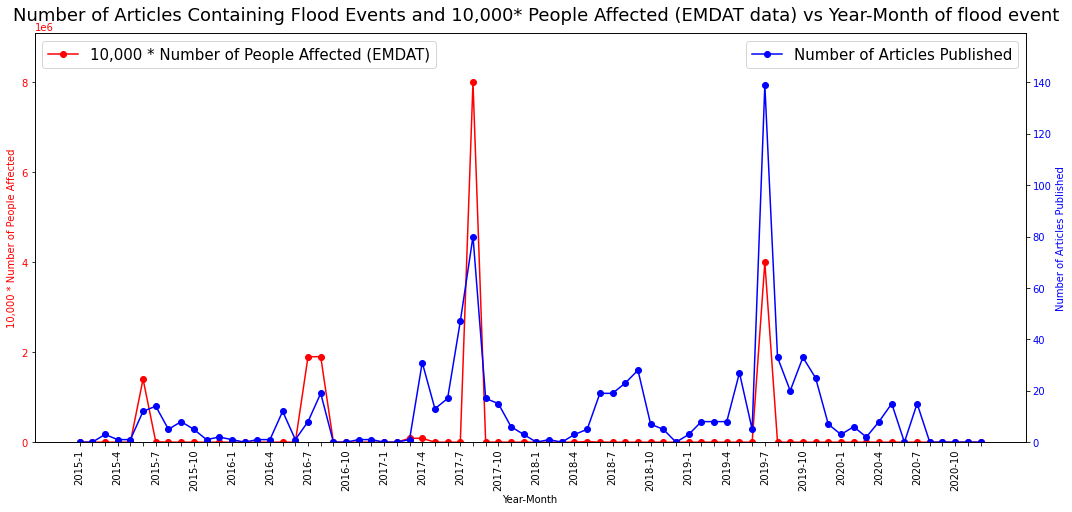

In [ ]:
year_month = []
for row in emdat_df.iterrows():
#     new_arr = []
    if int(row[1]['Start Month']):
        year_month.append(('{}-{}'.format(int(row[1]['Start Year']), int(row[1]['Start Month'])), 
                           row[1]['Total Affected']))
    if int(row[1]['End Month']):
        year_month.append(('{}-{}'.format(int(row[1]['End Year']), int(row[1]['End Month'])), 
                        row[1]['Total Affected']))

yearPublished_month_count_list_2020_2, year_month = match_years_months(yearPublished_month_count_list_2020, 
                                                                       year_month, [2015,None])
plot_2timeseries(
            {'count_list': year_month, 'label':'10,000 * Number of People Affected (EMDAT)', 
             'color':'r', 'ylabel':'10,000 * Number of People Affected'},
            {'count_list': yearPublished_month_count_list_2020_2, 'label':'Number of Articles Published', 
             'color': 'b', 'ylabel': 'Number of Articles Published'},
            'Number of Articles Containing Flood Events and 10,000* People Affected (EMDAT data) vs Year-Month of flood event', 'Year-Month', True, True)


#### Yearly People affected comparison with International Newspaper

<Figure size 1080x504 with 0 Axes>

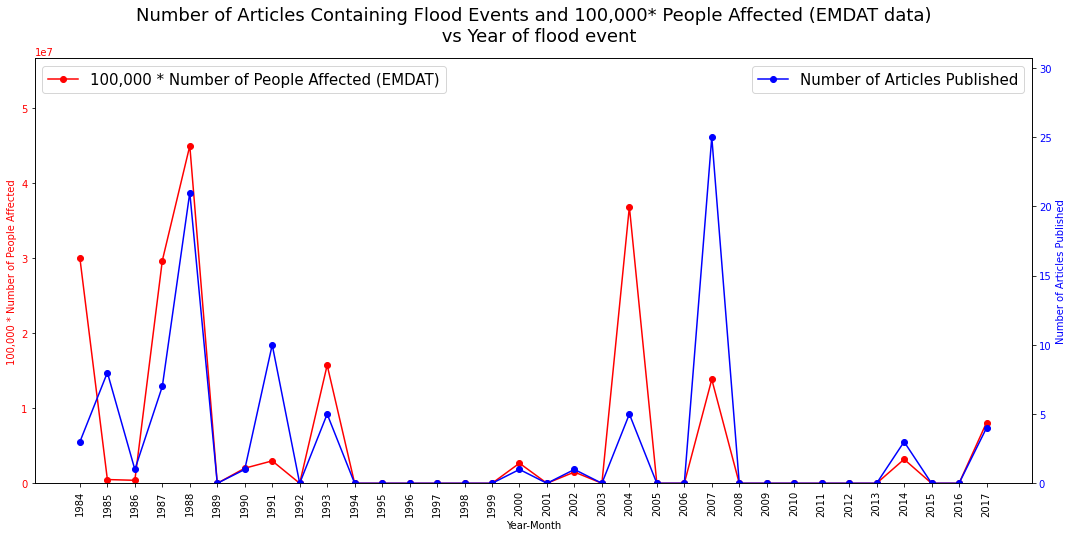

In [ ]:
international_newspaper_year = load_year(json.load(open('timeseries_data/international_newspaper.json'))['yearPublished'])
emdat_year = emdat_df.groupby('Start Year').sum()
emdat_year_totalAffected = json.loads(emdat_year['Total Affected'].to_json())

emdat_year_totalAffected2 = load_year(emdat_year_totalAffected, year_range=[None,2017])
international_newspaper_year, emdat_year_totalAffected2 = match_years(international_newspaper_year, 
                                                                   emdat_year_totalAffected2, match_type='remove', complete=True)
plot_2timeseries(
            {'count_list': emdat_year_totalAffected2, 'label':'100,000 * Number of People Affected (EMDAT)', 
             'color':'r', 'ylabel':'100,000 * Number of People Affected'},
            {'count_list': international_newspaper_year, 'label':'Number of Articles Published', 
             'color': 'b', 'ylabel': 'Number of Articles Published'},
            'Number of Articles Containing Flood Events and 100,000* People Affected (EMDAT data) \n vs Year of flood event', 'Year-Month', True)


## Detrending

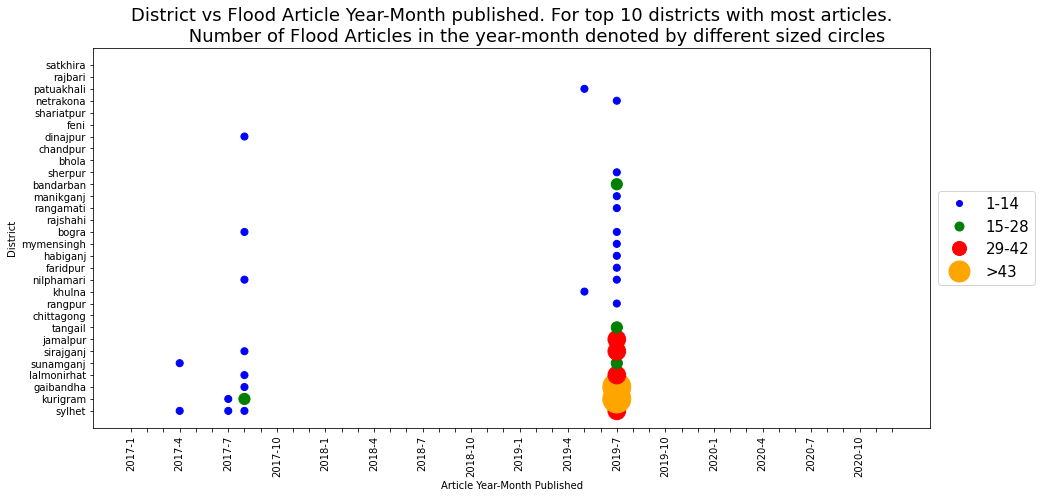

In [ ]:
def load_district_article_dist(filename, top=0):
    districts_n = json.load(open(filename))
    if top:
        dist_top = []
        for dname, dval in districts_n.items():
            year_monthPublished = dval['year_monthPublished']
            dist_top.append((dname, sum([i[1] for i in year_monthPublished])))
        dist_top.sort(key=lambda x:x[1], reverse=True)
        new_districts_n = {}
        for dist, distn in dist_top[:top]:
            new_districts_n[dist] = districts_n[dist]
        return new_districts_n
    return districts_n

def get_s_val(currVal, minVal, maxVal, div=4):
    diff = (maxVal-minVal)//div
    return 20*2.5**(currVal//diff) if currVal//diff else 0

def get_colors(currVal, minVal, maxVal, div=4):
    colors = ['#FFFF00','#0000FF','#008000','#FF0000','#FFA500']
    diff = (maxVal-minVal)//div
    return colors[currVal//diff]

def get_labels(currVal, minVal, maxVal, div=4):
    diff = (maxVal-minVal)//div
    if currVal==0: return ''
    for i in range(div):
        if i==div-1: return '>{}'.format((diff*i)+1)
        if (diff*i)+1 <= currVal <= diff*(i+1):
            return '{}-{}'.format((diff*i)+1,diff*(i+1))
    return ''
    
def plot_district_articles_distribution(districts_n, title=None, xlabel=None, ylabel=None, 
                                        xticks_rotate=True, skip=True):
    from matplotlib.lines import Line2D

    div = 4
    fig, ax = plt.subplots(figsize=(15,7))
    xvals = [i[0] for i in districts_n['sylhet']['year_monthPublished']]
    yvals_name = list(districts_n)
    yvals = [[districts_n[dname]['year_monthPublished'][i][1] for dname in yvals_name] for i,ym in enumerate(xvals)]
    maxVal, minVal = -float('inf'), float('inf')
    for y in yvals:
        for count in y:
            maxVal, minVal = max(maxVal, count), min(minVal, count)
    for i in range(len(xvals)):
        ax.scatter([xvals[i]]*len(yvals[i]), range(len(yvals[i])), 
                   s=[get_s_val(i,minVal,maxVal) for i in yvals[i]], 
                   c=[get_colors(i,minVal,maxVal) for i in yvals[i]])
    legend_elements = [Line2D([0], [0], linewidth=0, marker='o', 
                              color=get_colors(((maxVal-minVal)//div)*i, minVal, maxVal), 
                              label=get_labels(((maxVal-minVal)//div)*i, minVal, maxVal),
                              markerfacecolor=get_colors(((maxVal-minVal)//div)*i, minVal, maxVal), 
                              markersize=i**2+5)
                       for i in range(div+1) if i!=0
                   ]
    
    plt.legend(handles=legend_elements, fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))
    if not title: title = 'District vs Flood Article Year-Month published. For top 10 districts with most articles.\n \
        Number of Flood Articles in the year-month denoted by different sized circles'
    if not xlabel: xlabel = 'Article Year-Month Published'
    if not ylabel: ylabel = 'District'
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks(range(len(yvals_name)), labels=yvals_name)
    if xticks_rotate: plt.xticks(rotation='vertical')
    if skip:
        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::3]))
        for label in temp:
            label.set_visible(False)
    plt.show()
districts_n = load_district_article_dist('timeseries_data/district_articles_dist.json', top=30)
plot_district_articles_distribution(districts_n)